# Imports

In [20]:
import torch
import torch.nn as nn
import random
import hashlib
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter
from skimage import exposure
import os
from shutil import copyfile
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F


import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


# Define transforms

In [2]:
# Define transformations for the training data and testing data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Data Loaders

In [9]:
# Load the dataset
dataset = datasets.ImageFolder(r'C:\Users\amitb\Deep Learning\nike-ds-project\data', transform=transform)

# Splitting the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


# Display a batch of images

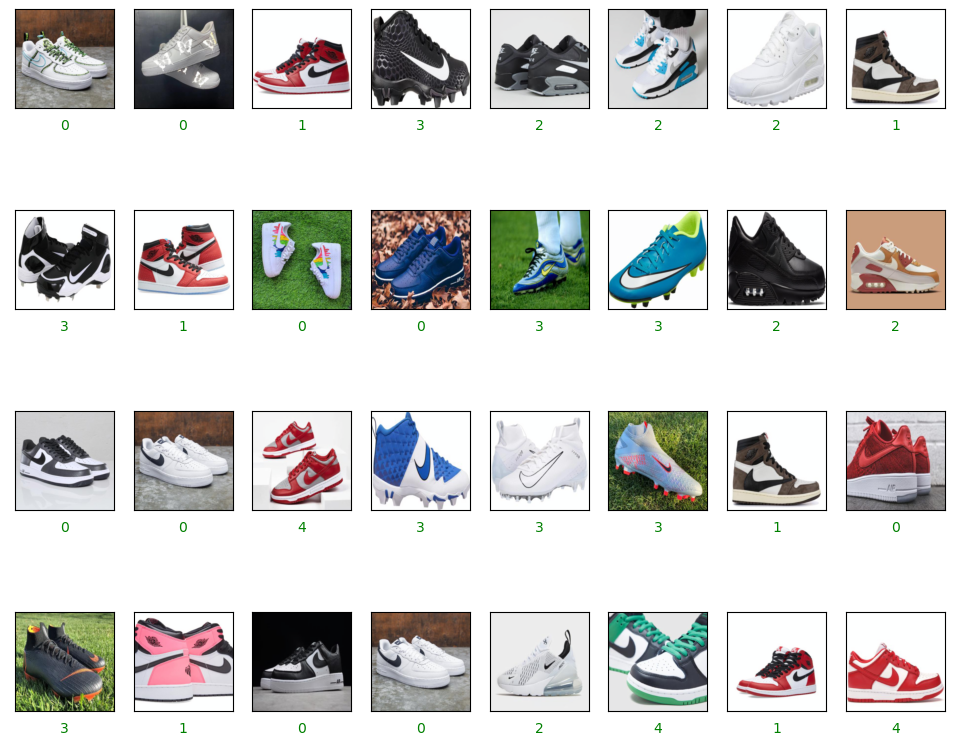

In [11]:
# Function to show a batch of images
def show_images(images, labels, preds):
    plt.figure(figsize=(12, 10))
    for i, image in enumerate(images):
        plt.subplot(4, 8, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{preds[i]}', color=col)

# Get a batch of training data
images, labels = next(iter(train_loader))
show_images(images, labels, labels)


# Define Model

In [43]:
class CNN(nn.Module):
    def __init__(self):  # Assuming 5 classes, change as needed
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)  # The size here should match the flattened size
        self.fc2 = nn.Linear(120, 84)
        self.out = nn.Linear(84,5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 54*54*16)  # Adjust this to match the output from the conv layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.out(x), dim=1)
        return x



# Instantiate the model, define loss and optimization functions

In [44]:
torch.manual_seed(101)
CNN_model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.0001)
CNN_model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=5, bias=True)
)

# Calculating the number of parameters

In [45]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [46]:
count_parameters(CNN_model)

     162
       6
     864
      16
 5598720
     120
   10080
      84
     420
       5
________
 5610477


# Train the model

In [47]:
import time  
start_time = time.time()

epochs = 8  

max_train_batch = 2400
max_test_batch = 900

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        # limit the number of batches 
        if b == max_train_batch:
            break
        
        b += 1

        # apply the model
        y_pred = CNN_model(X_train)
        loss = criterion(y_pred, y_train)

        # count the number of correct predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/18743]  loss: {loss.item():10.8f}  \
accuracy: {train_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.detach().numpy())
    train_correct.append(train_corr.detach().numpy())


    # run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # limit the number of batches 
            if b == max_test_batch:
                break

            # apply the model
            y_val = CNN_model(X_test)

            # Count the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(test_corr.detach().numpy())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed


Duration: 173 seconds


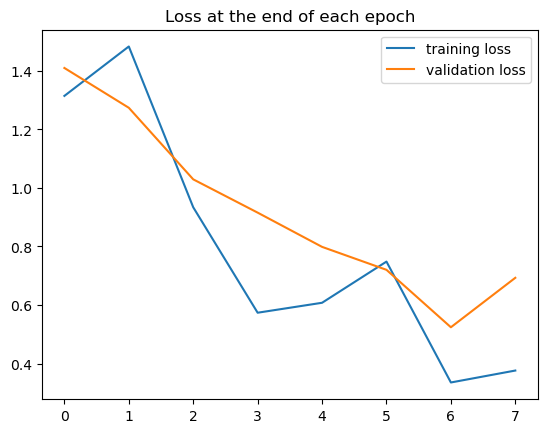

In [48]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

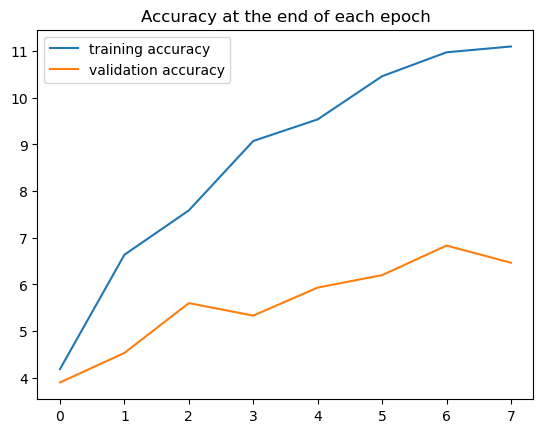

In [49]:
#plt.plot([t/180 for t in train_correct], label='training accuracy')
#plt.plot([t/60 for t in test_correct], label='validation accuracy')
plt.plot([t/80 for t in train_correct], label='training accuracy')
plt.plot([t/30 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [50]:
print(test_correct)
#print(f'Test Accuracy: {test_correct[-1].item()*100/len(test_data)}')
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[array(117, dtype=int64), array(136, dtype=int64), array(168, dtype=int64), array(160, dtype=int64), array(178, dtype=int64), array(186, dtype=int64), array(205, dtype=int64), array(194, dtype=int64)]
Test accuracy: 6.467%
